In [73]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [74]:
fingertype = {
    'real': '01',
    'altered': '02',
}

In [75]:
dataset="C://Users//tatba//OneDrive//Desktop//Dataset//Fingerprintscan"

In [76]:
# Image parameters
img_height, img_width = 128, 128

In [77]:
# Load images and labels from filenames
def load_data(path):
    images = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith('.BMP'):
            # Load image manually using cv2
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (img_width, img_height))
            img_array = img / 255.0  # Normalize
            images.append(img_array)
            # Extract emotion from filename (3rd element in the filename)
            finger_code = filename.split('-')[0]
            finger_label = fingertype[finger_code]
            labels.append(finger_code)
    return np.array(images), np.array(labels)

In [78]:
# Load the dataset
X, y = load_data(dataset)

In [79]:
# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [80]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [81]:
# Convert labels to categorical (one-hot encoding)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [82]:
# Define a simple CNN model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [83]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 32,011,266 (122.11 MB)

 Trainable params: 31,957,378 (121.91 MB)

 Non-trainable params: 53,888 (210.50 KB)

In [84]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
loss='binary_crossentropy',
metrics=['accuracy'])

In [85]:
history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=16
)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.6667 - loss: 0.8409 - val_accuracy: 0.5643 - val_loss: 2.9871
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7552 - loss: 0.6588 - val_accuracy: 0.5643 - val_loss: 147.0817
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7861 - loss: 0.5497 - val_accuracy: 0.5643 - val_loss: 225.3729
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7918 - loss: 0.4896 - val_accuracy: 0.4357 - val_loss: 0.7213
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8655 - loss: 0.3754 - val_accuracy: 0.4357 - val_loss: 1.1148
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8609 - loss: 0.3400 - val_accuracy: 0.4357 - val_loss: 0.9199
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9024 - loss: 0.2720 - val_accuracy: 0.4357 - val_loss: 0.8834
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9009 - loss: 0.2756 - val_accuracy: 0.4357 - val_l

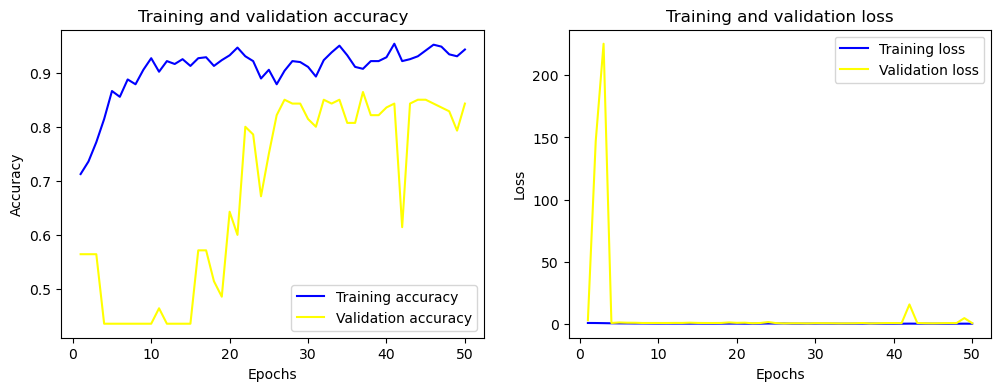

In [86]:
# Plot training & validation accuracy/loss
def plot_accuracy_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc,color='blue', label='Training accuracy')
    plt.plot(epochs, val_acc,color='yellow', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss,color='blue', label='Training loss')
    plt.plot(epochs, val_loss,color='yellow', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_accuracy_loss(history)

In [87]:
# Get predictions
Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 686ms/step


Classification Report
              precision    recall  f1-score   support

        real       0.90      0.81      0.85        79
     altered       0.78      0.89      0.83        61

    accuracy                           0.84       140
   macro avg       0.84      0.85      0.84       140
weighted avg       0.85      0.84      0.84       140

Confusion Matrix
[[64 15]
 [ 7 54]]


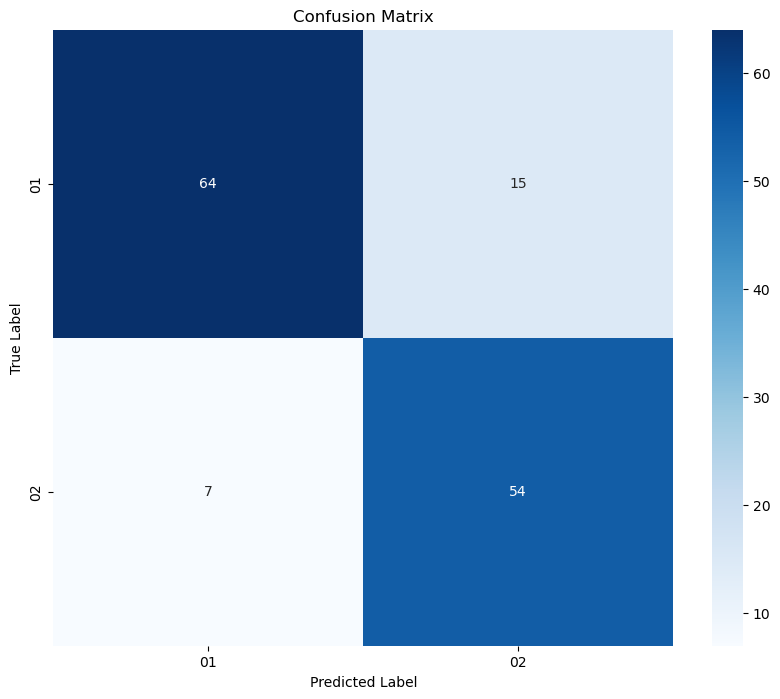

In [88]:
# Confusion matrix and classification report
clr = classification_report(y_val, y_pred, target_names=fingertype)
print("Classification Report")
print(clr)

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)
labels = list(fingertype.values())
print("Confusion Matrix")
print(cm) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

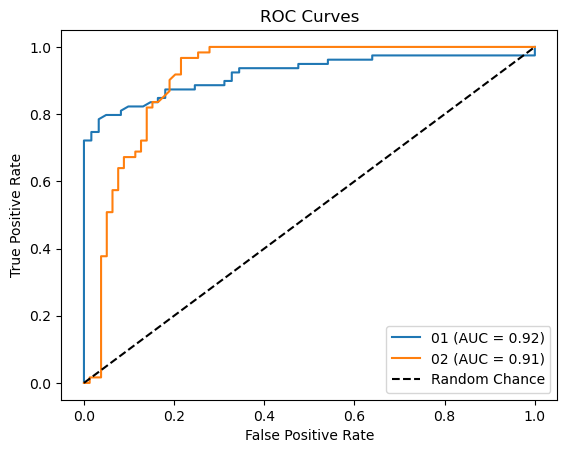

In [89]:
# Binarize labels for ROC-AUC
n_classes = len(labels)
y_val_bin = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_pred_bin = tf.keras.utils.to_categorical(y_pred, num_classes=n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()